# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

warnings.simplefilter("ignore")

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [5]:
# Loading the dataset
# eg.
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
dirpath1 = './dataset/IMFDB/'
X1,y1 = load_data(dirpath1)
dirpath2 = './dataset/Yale_face_database/'
X2,y2 = load_data(dirpath2)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
N1,H1,W1 = X1.shape[0:3]
C1 = 1 if opt['is_grayscale'] else X1.shape[3]
N2,H2,W2 = X2.shape[0:3]
C2 = 1 if opt['is_grayscale'] else X2.shape[3]
X1 = X1.reshape((N1,H1*W1*C1))
X2 = X2.reshape((N2,H2*W2*C2))

Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


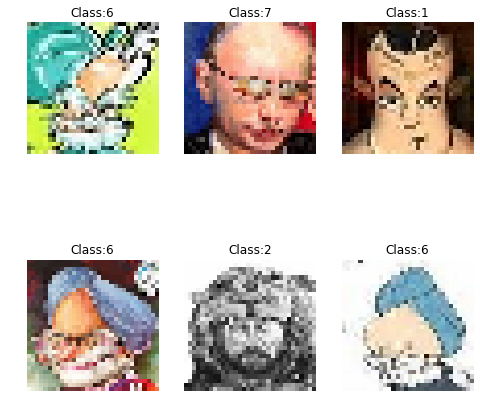

In [6]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [7]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [8]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k,pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [9]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k,kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [10]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k,lda

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [11]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k,klda

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [12]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [13]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

Eigenfaces is the name given to a set of eigenvectors when they are used in the computer vision problem of human face recognition.A set of eigenfaces can be generated by performing a mathematical process called principal component analysis (PCA) on a large set of images depicting different human faces. Informally, eigenfaces can be considered a set of "standardized face ingredients", derived from statistical analysis of many pictures of faces. Any human face can be considered to be a combination of these standard faces. For example, one's face might be composed of the average face plus 10% from eigenface 1, 55% from eigenface 2, and even −3% from eigenface 3.

Eigenfaces are the eigenvectors of the covariance ma-
trix of face images, and are used in the field of com-
puter vision in facial recognition, and in general pat-
tern recognition.
___________________________

Your answers here (double click to edit)


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

The eigenvectors/faces from the eigen value spectrum is taken whose sum of eigenvalues is 0.95 of the total sum and used for reconstruction.

This ratio is kept below 5 - 10 percent for efficient recontruction. (First k eigen vectors are taken)

\begin{equation*}
ratio = \frac{(\sum_{i=k+1}^d \lambda_i )} {(\sum_{i=1}^d \lambda_i )} 
\end{equation*}

These can “satisfactorily” reconstruct a  person  in  these  three  datasets.

IIIT CFW - about 300 to 350 , I have taken 310

IMFDB - about 110 to 130 , I have taken 120

Yale faces dataset - about 50 to 70 , I have taken 60

In [14]:
# Compute your features 
# eg.
k=310
k1=120
k2=60
X_3D, pca = get_pca(X,k)
X1_3D, pca1 = get_pca(X1,k1)
X2_3D, pca2 = get_pca(X2,k2)

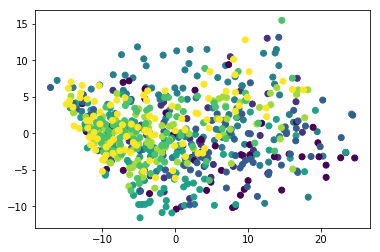

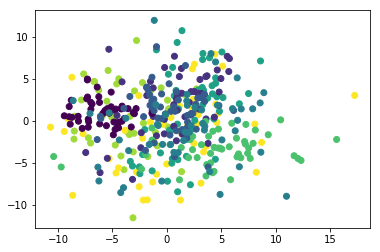

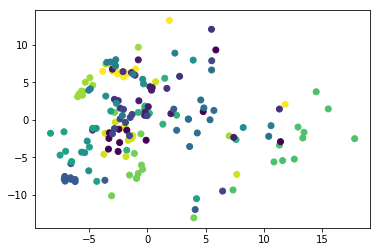

In [15]:
# PCA 2D plots
pca = PCA(n_components=2)
pca.fit(X_3D) 
plt.scatter(X_3D[:,0],X_3D[:,1],c=y)
plt.show()

pca = PCA(n_components=2)
pca.fit(X1_3D) 
plt.scatter(X1_3D[:,0],X1_3D[:,1],c=y1)
plt.show()

pca = PCA(n_components=2)
pca.fit(X2_3D) 
plt.scatter(X2_3D[:,0],X2_3D[:,1],c=y2)
plt.show()

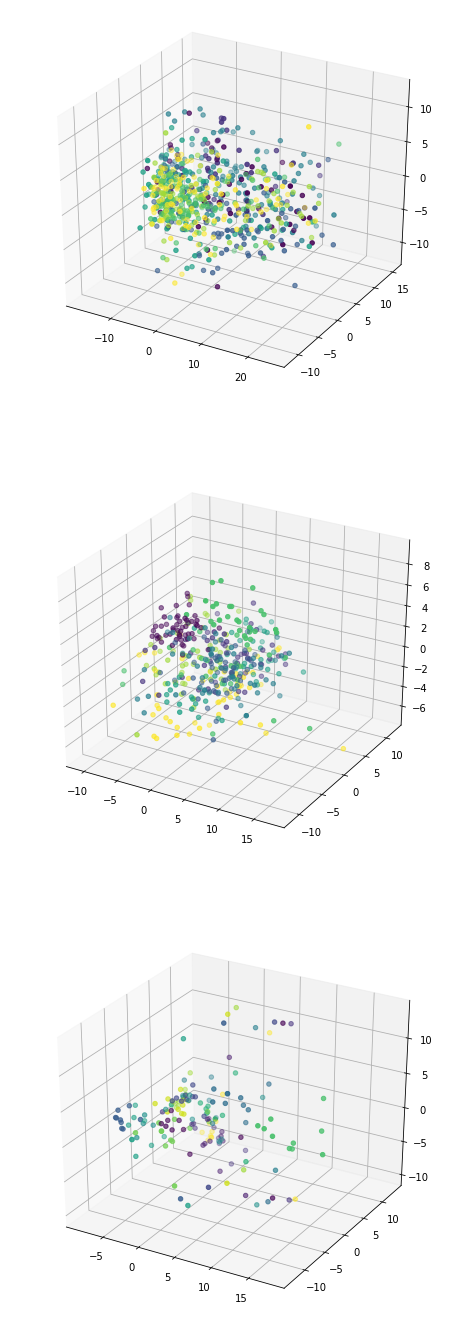

In [16]:
# Create a scatter plot PCA for 3d 
# eg.
fig = plt.figure(figsize=(8,24))
ax = fig.add_subplot(311, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)
ax = fig.add_subplot(312, projection='3d')
ax.scatter(X1_3D[:,0],X1_3D[:,1],X1_3D[:,2],c=y1)
ax = fig.add_subplot(313, projection='3d')
ax.scatter(X2_3D[:,0],X2_3D[:,1],X2_3D[:,2],c=y2)



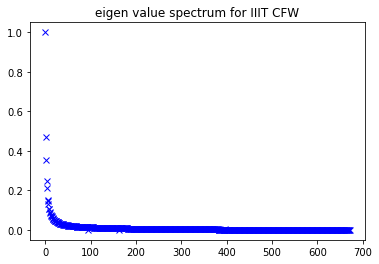

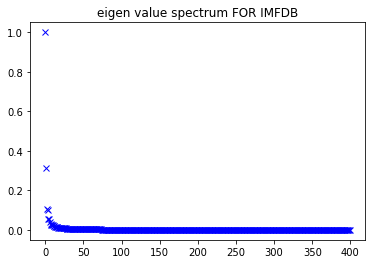

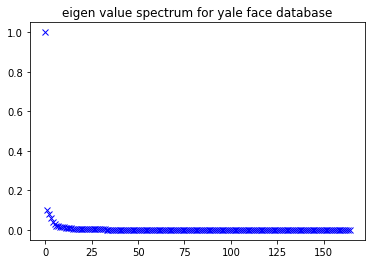

In [17]:
# Plot the eigen value spectrum 
from numpy import linalg as LA
from numpy.linalg import matrix_rank
data1transpose = X
covmat1 = np.cov(data1transpose)
eigenval1,eigenvec1 = LA.eig(covmat1)
norm_eigenval1 = (eigenval1 - min(eigenval1))/(max(eigenval1) - min(eigenval1))
# print(norm_eigenval1)
plt.plot(norm_eigenval1,'bx')
plt.title('eigen value spectrum for IIIT CFW')
plt.show()

data1transpose1 = X1
covmat11 = np.cov(data1transpose1)
eigenval11,eigenvec11 = LA.eig(covmat11)
norm_eigenval11 = (eigenval11 - min(eigenval11))/(max(eigenval11) - min(eigenval11))
# print(norm_eigenval1)
plt.plot(norm_eigenval11,'bx')
plt.title('eigen value spectrum FOR IMFDB')
plt.show()

data1transpose2 = X2
covmat12 = np.cov(data1transpose2)
eigenval12,eigenvec12 = LA.eig(covmat12)
norm_eigenval12 = (eigenval12 - min(eigenval12))/(max(eigenval12) - min(eigenval12))
# print(norm_eigenval1)
plt.plot(norm_eigenval12,'bx')
plt.title('eigen value spectrum for yale face database')
plt.show()


1(c). Reconstruct  the  image  back for each case


In [18]:
def reconstruct_images():
    reconstruct_X = pca.inverse_transform(X_3D)
    return reconstruct_X    
def reconstruct_images1():
    reconstruct_X1 = pca1.inverse_transform(X1_3D)
    return reconstruct_X1    
def reconstruct_images2():
    reconstruct_X2 = pca2.inverse_transform(X2_3D)
    return reconstruct_X2    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


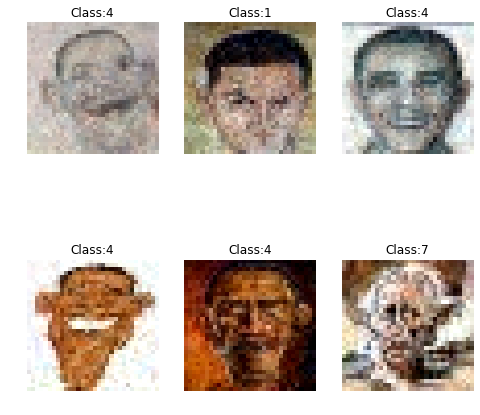

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstruction loss for IIIT CFW
0.06718508353081844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


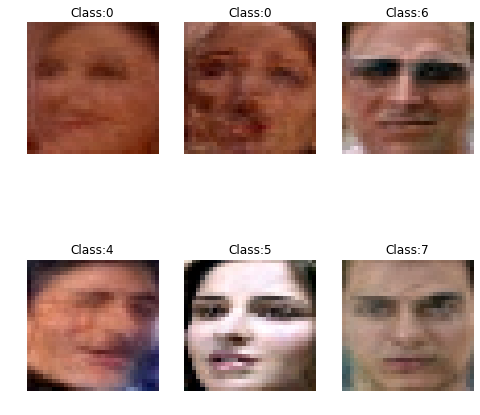

Reconstruction loss for IMFDB
0.03916113971651866


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


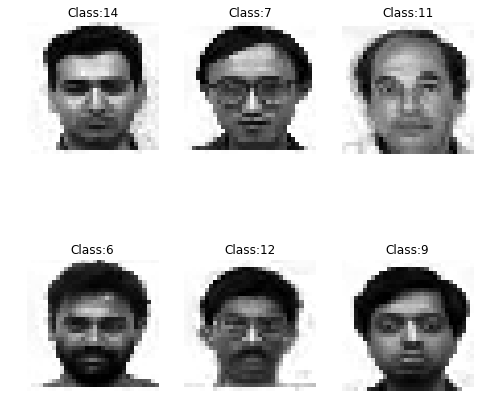

Reconstruction loss for yale face database
0.05392062592168841


In [19]:
# Display results 
X_3D, pca = get_pca(X,k)
X1_3D, pca1 = get_pca(X1,k1)
X2_3D, pca2 = get_pca(X2,k2)

X_reconstruced = reconstruct_images()
X1_reconstruced = reconstruct_images1()
X2_reconstruced = reconstruct_images2()

# print(np.shape(X_reconstruced))
X_reconstruced_3D=[]
X1_reconstruced_3D=[]
X2_reconstruced_3D=[]

for i in range(0,672):
    temp = X_reconstruced[i]
    temp1 = np.reshape(temp,(32,32,3))
    X_reconstruced_3D.append(temp1)
ind = np.random.randint(0,y.shape[0],6)
disply_images(np.array(X_reconstruced_3D)[ind,...],y[ind],row=2,col=3)
print("Reconstruction loss for IIIT CFW")
print(np.sqrt(np.mean((X - X_reconstruced)**2)))

for i in range(0,400):
    temp = X1_reconstruced[i]
    temp1 = np.reshape(temp,(32,32,3))
    X1_reconstruced_3D.append(temp1)
ind = np.random.randint(0,y1.shape[0],6)
disply_images(np.array(X1_reconstruced_3D)[ind,...],y1[ind],row=2,col=3)
print("Reconstruction loss for IMFDB")
print(np.sqrt(np.mean((X1 - X1_reconstruced)**2)))

for i in range(0,165):
    temp = X2_reconstruced[i]
    temp1 = np.reshape(temp,(32,32,3))
    X2_reconstruced_3D.append(temp1)
ind = np.random.randint(0,y2.shape[0],6)
disply_images(np.array(X2_reconstruced_3D)[ind,...],y2[ind],row=2,col=3)
print("Reconstruction loss for yale face database")
print(np.sqrt(np.mean((X2 - X2_reconstruced)**2)))

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

For every dataset, we calculate the reconstruction loss for each class in the dataset and conclude that the class with the highest loss will be the hardest to represent with few eigen vectors. With more eigen vectors though this error can be minimised.

IIIT CFW - class 5 Narendra Modi id hardest to represent

IMFDB - class 7 Amir Khan is hardest to represent

Yale face database - class 7 is hardest to represent 

On the whole since yale face dataset has highest reconstruction error, it is the hardest to represent with few eifrn vectors.

In [20]:
# code goes here
# For X
ex=[]
print("")
for i in range(8):
    temp = X[y == i]
    X3, pca = get_pca(temp,20)
    reconstruct_X = pca.inverse_transform(X3)
    ex.append(np.sqrt(np.mean((temp - reconstruct_X)**2)))
min=-1
label = 0
for i in range(len(ex)):
    if ex[i] > min:
        min = ex[i]
        label=i
print("This class is the hardest to represent in IIIT CFW dataset as it has the highest loss")
print(label)
        

ex1=[]
print("")
for i in range(8):
    temp = X1[y1 == i]
    X4, pca = get_pca(temp,15)
    reconstruct_X = pca.inverse_transform(X4)
    ex1.append(np.sqrt(np.mean((temp - reconstruct_X)**2)))
min=-1
label = 0
for i in range(len(ex1)):
    if ex1[i] > min:
        min = ex1[i]
        label=i
print("This class is the hardest to represent in IMFDB dataset as it has the highest loss")
print(label)

ex2=[]
print("")
for i in range(13):
    temp = X2[y2 == i]
    X5, pca = get_pca(temp,3)
    reconstruct_X = pca.inverse_transform(X5)
    ex2.append(np.sqrt(np.mean((temp - reconstruct_X)**2)))
min=-1
label = 0
for i in range(len(ex2)):
    if ex2[i] > min:
        min = ex2[i]
        label=i
print("This class is the hardest to represent in yale face dataset as it has the highest loss")
print(label)
    

    


This class is the hardest to represent in IIIT CFW dataset as it has the highest loss
5

This class is the hardest to represent in IMFDB dataset as it has the highest loss
7

This class is the hardest to represent in yale face dataset as it has the highest loss
7


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy.

Csv files have been attached in my project submission folder tabulating all the accuracies and results
Usually PCA+LDA with any classifier and RESNET showed good accuracy while KPCA and other methos like PCA had lesser acuracy


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

cf=[]
a1=[]
r1=[]
e1=[]
shap=[]
d1=[]

class Classifier():
    def __init__(self,X_train,X_validate,y_train,y_validate):
        self.X_train = X_train
        self.X_validate = X_validate
        self.y_train = y_train
        self.y_validate = y_validate
        self.pred = []
        
    def confusion_matrix(self,pred,y):
        arr = confusion_matrix(y,pred)
        cf.append(arr)
        pre = precision_score(y,pred,average='weighted')
        rec = recall_score(y,pred,average='weighted')
        eff1 = f1_score(y, pred, average='weighted') 
        e1.append(eff1)
        
    def train_and_test(self,X_train,y_train,num):
        d1.append(X_train.shape[1])
        if(num==1):
            clf = MLPClassifier(hidden_layer_sizes=(10,), alpha=1e-4,solver='lbfgs',random_state=1).fit(X_train,y_train)
            prediction=clf.predict(self.X_validate)
            acc=clf.score(self.X_validate,self.y_validate)
            print(acc*100)
            a1.append(acc*100)
            err = 1-acc
            r1.append(err*100)
            self.confusion_matrix(prediction,self.y_validate)
        
        if(num==2):
            clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train,y_train)
            prediction=clf.predict(self.X_validate)
            acc=clf.score(self.X_validate,self.y_validate)
            print(acc*100)
            a1.append(acc*100)
            err = 1-acc
            r1.append(err*100)
            self.confusion_matrix(prediction,self.y_validate)
            
        if(num==3):
            clf = SVC(gamma='scale', decision_function_shape = 'ovo').fit(X_train,y_train)
            prediction=clf.predict(self.X_validate)
            acc=clf.score(self.X_validate,self.y_validate)
            print(acc*100)
            a1.append(acc*100)
            err = 1-acc
            r1.append(err*100)
            self.confusion_matrix(prediction,self.y_validate)
            
        if(num==4):
            clf = DecisionTreeClassifier(random_state=0,max_depth=16).fit(X_train,y_train)
            prediction=clf.predict(self.X_validate)
            acc=clf.score(self.X_validate,self.y_validate)
            print(acc*100)
            a1.append(acc*100)
            err = 1-acc
            r1.append(err*100)
            self.confusion_matrix(prediction,self.y_validate)

        # Create a confusion matrix
        # Calculate Validation accuracy 
        # Calculate precision and recall 
        # Calculate F1-score
    
        return 

In [22]:
# Create a train and validation split to train your classifier 

from sklearn.model_selection import train_test_split
print("Printing accuracies to find the best feature classifier model")
print("The accuracies for MLP LR SVM and decision tree are printed respectively for each feature representation and each dataset")
print("PCA")
X_train,X_validate,y_train,y_validate=train_test_split(X,y,test_size=0.2)
X_3D,pca = get_pca(X_train,310)
X_validate=pca.transform(X_validate)
a=X_validate
print("IIIT CFT")
classifier = Classifier(X_3D,X_validate,y_train,y_validate)
classifier.train_and_test(X_3D,y_train,1)
classifier.train_and_test(X_3D,y_train,2)
classifier.train_and_test(X_3D,y_train,3)
classifier.train_and_test(X_3D,y_train,4)

X1_train,X1_validate,y1_train,y1_validate=train_test_split(X1,y1,test_size=0.2)
X1_3D,pca = get_pca(X1_train,120)
X1_validate=pca.transform(X1_validate)
b=X1_validate
print("IMFDB")
classifier1 = Classifier(X1_3D,X1_validate,y1_train,y1_validate)
classifier1.train_and_test(X1_3D,y1_train,1)
classifier1.train_and_test(X1_3D,y1_train,2)
classifier1.train_and_test(X1_3D,y1_train,3)
classifier1.train_and_test(X1_3D,y1_train,4)

X2_train,X2_validate,y2_train,y2_validate=train_test_split(X2,y2,test_size=0.2)
X2_3D,pca = get_pca(X2_train,60)
X2_validate=pca.transform(X2_validate)
c=X2_validate
print("Yale Face Database")
classifier2 = Classifier(X2_3D,X2_validate,y2_train,y2_validate)
classifier2.train_and_test(X2_3D,y2_train,1)
classifier2.train_and_test(X2_3D,y2_train,2)
classifier2.train_and_test(X2_3D,y2_train,3)
classifier2.train_and_test(X2_3D,y2_train,4)


print(" ")
print("KPCA")
X_train,X_validate,y_train,y_validate,X1_train,X1_validate,y1_train,y1_validate,X2_train,X2_validate,y2_train,y2_validate =[],[],[],[],[],[],[],[],[],[],[],[] 
X_train,X_validate,y_train,y_validate=train_test_split(X,y,test_size=0.2)
X_3D_1,kpca = get_kernel_pca(X_train,310)
X_validate = kpca.transform(X_validate)
print("IIIT CFT")
classifier = Classifier(X_3D_1,X_validate,y_train,y_validate)
classifier.train_and_test(X_3D_1,y_train,1)
classifier.train_and_test(X_3D_1,y_train,2)
classifier.train_and_test(X_3D_1,y_train,3)
classifier.train_and_test(X_3D_1,y_train,4)

X1_train,X1_validate,y1_train,y1_validate=train_test_split(X1,y1,test_size=0.2)
X1_3D_1,kpca = get_kernel_pca(X1_train,120)
X1_validate = kpca.transform(X1_validate)
print("IMFDB")
classifier1 = Classifier(X1_3D_1,X1_validate,y1_train,y1_validate)
classifier1.train_and_test(X1_3D_1,y1_train,1)
classifier1.train_and_test(X1_3D_1,y1_train,2)
classifier1.train_and_test(X1_3D_1,y1_train,3)
classifier1.train_and_test(X1_3D_1,y1_train,4)

X2_train,X2_validate,y2_train,y2_validate=train_test_split(X2,y2,test_size=0.2)
X2_3D_1,kpca = get_kernel_pca(X2_train,60)
X2_validate = kpca.transform(X2_validate)
print("Yale Face Database")
classifier2 = Classifier(X2_3D_1,X2_validate,y2_train,y2_validate)
classifier2.train_and_test(X2_3D_1,y2_train,1)
classifier2.train_and_test(X2_3D_1,y2_train,2)
classifier2.train_and_test(X2_3D_1,y2_train,3)
classifier2.train_and_test(X2_3D_1,y2_train,4)


print(" ")
print("PCA+LDA")
X_train,X_validate,y_train,y_validate,X1_train,X1_validate,y1_train,y1_validate,X2_train,X2_validate,y2_train,y2_validate =[],[],[],[],[],[],[],[],[],[],[],[] 

X_train,X_validate,y_train,y_validate=train_test_split(X,y,test_size=0.2)
X_3D,pca = get_pca(X_train,310)
X_validate=pca.transform(X_validate)
X_3D_2,lda = get_lda(X_3D,y_train,310)
X_validate=lda.transform(X_validate)
print("IIIT CFT")
classifier = Classifier(X_3D_2,X_validate,y_train,y_validate)
classifier.train_and_test(X_3D_2,y_train,1)
classifier.train_and_test(X_3D_2,y_train,2)
classifier.train_and_test(X_3D_2,y_train,3)
classifier.train_and_test(X_3D_2,y_train,4)

X1_train,X1_validate,y1_train,y1_validate=train_test_split(X1,y1,test_size=0.2)
X1_3D,pca = get_pca(X1_train,120)
X1_validate=pca.transform(X1_validate)
X1_3D_2,lda = get_lda(X1_3D,y1_train,120)
X1_validate=lda.transform(X1_validate)
print("IMFDB")
classifier1 = Classifier(X1_3D_2,X1_validate,y1_train,y1_validate)
classifier1.train_and_test(X1_3D_2,y1_train,1)
classifier1.train_and_test(X1_3D_2,y1_train,2)
classifier1.train_and_test(X1_3D_2,y1_train,3)
classifier1.train_and_test(X1_3D_2,y1_train,4)

X2_train,X2_validate,y2_train,y2_validate=train_test_split(X2,y2,test_size=0.2)
X2_3D,pca = get_pca(X2_train,60)
X2_validate=pca.transform(X2_validate)
X2_3D_2,lda = get_lda(X2_3D,y2_train,60)
X2_validate=lda.transform(X2_validate)
print("Yale Face Database")
classifier2 = Classifier(X2_3D_2,X2_validate,y2_train,y2_validate)
classifier2.train_and_test(X2_3D_2,y2_train,1)
classifier2.train_and_test(X2_3D_2,y2_train,2)
classifier2.train_and_test(X2_3D_2,y2_train,3)
classifier2.train_and_test(X2_3D_2,y2_train,4)

print(" ")
print("KLDA")
X_train,X_validate,y_train,y_validate,X1_train,X1_validate,y1_train,y1_validate,X2_train,X2_validate,y2_train,y2_validate =[],[],[],[],[],[],[],[],[],[],[],[] 

X_train,X_validate,y_train,y_validate=train_test_split(X,y,test_size=0.2)
X_3D_3,klda = get_kernel_lda(X_train,y_train,310)
X_validate=klda.transform(X_validate)
print("IIIT CFT")
classifier = Classifier(X_3D_3,X_validate,y_train,y_validate)
classifier.train_and_test(X_3D_3,y_train,1)
classifier.train_and_test(X_3D_3,y_train,2)
classifier.train_and_test(X_3D_3,y_train,3)
classifier.train_and_test(X_3D_3,y_train,4)

X1_train,X1_validate,y1_train,y1_validate=train_test_split(X1,y1,test_size=0.2)
X1_3D_3,klda = get_kernel_lda(X1_train,y1_train,120)
X1_validate=klda.transform(X1_validate)
print("IMFDB")
classifier1 = Classifier(X1_3D_3,X1_validate,y1_train,y1_validate)
classifier1.train_and_test(X1_3D_3,y1_train,1)
classifier1.train_and_test(X1_3D_3,y1_train,2)
classifier1.train_and_test(X1_3D_3,y1_train,3)
classifier1.train_and_test(X1_3D_3,y1_train,4)

X2_train,X2_validate,y2_train,y2_validate=train_test_split(X2,y2,test_size=0.2)
X2_3D_3,klda = get_kernel_lda(X2_train,y2_train,60)
X2_validate=klda.transform(X2_validate)
print("Yale Face Database")
classifier2 = Classifier(X2_3D_3,X2_validate,y2_train,y2_validate)
classifier2.train_and_test(X2_3D_3,y2_train,1)
classifier2.train_and_test(X2_3D_3,y2_train,2)
classifier2.train_and_test(X2_3D_3,y2_train,3)
classifier2.train_and_test(X2_3D_3,y2_train,4)

print(" ")
print("RESNET")
X_train,X_validate,y_train,y_validate,X1_train,X1_validate,y1_train,y1_validate,X2_train,X2_validate,y2_train,y2_validate =[],[],[],[],[],[],[],[],[],[],[],[] 
X_3D_5 = get_resnet_features(dirpath)
X1_3D_5 = get_resnet_features(dirpath1)
X2_3D_5 = get_resnet_features(dirpath2)

X_train,X_validate,y_train,y_validate=train_test_split(X_3D_5,y,test_size=0.2)
print("IIIT CFT")
classifier = Classifier(X_train,X_validate,y_train,y_validate)
classifier.train_and_test(X_train,y_train,1)
classifier.train_and_test(X_train,y_train,2)
classifier.train_and_test(X_train,y_train,3)
classifier.train_and_test(X_train,y_train,4)

X1_train,X1_validate,y1_train,y1_validate=train_test_split(X1_3D_5,y1,test_size=0.2)
print("IMFDB")
classifier1 = Classifier(X1_train,X1_validate,y1_train,y1_validate)
classifier1.train_and_test(X1_train,y1_train,1)
classifier1.train_and_test(X1_train,y1_train,2)
classifier1.train_and_test(X1_train,y1_train,3)
classifier1.train_and_test(X1_train,y1_train,4)

X2_train,X2_validate,y2_train,y2_validate=train_test_split(X2_3D_5,y2,test_size=0.2)
print("Yale Face Database")
classifier2 = Classifier(X2_train,X2_validate,y2_train,y2_validate)
classifier2.train_and_test(X2_train,y2_train,1)
classifier2.train_and_test(X2_train,y2_train,2)
classifier2.train_and_test(X2_train,y2_train,3)
classifier2.train_and_test(X2_train,y2_train,4)

print(" ")
print("VGG")
X_train,X_validate,y_train,y_validate,X1_train,X1_validate,y1_train,y1_validate,X2_train,X2_validate,y2_train,y2_validate =[],[],[],[],[],[],[],[],[],[],[],[] 
X_3D_4 = get_vgg_features(dirpath)
X1_3D_4 = get_vgg_features(dirpath1)
X2_3D_4 = get_vgg_features(dirpath2)

X_train,X_validate,y_train,y_validate=train_test_split(X_3D_4,y,test_size=0.2)
print("IIIT CFT")
classifier = Classifier(X_train,X_validate,y_train,y_validate)
classifier.train_and_test(X_train,y_train,1)
classifier.train_and_test(X_train,y_train,2)
classifier.train_and_test(X_train,y_train,3)
classifier.train_and_test(X_train,y_train,4)

X1_train,X1_validate,y1_train,y1_validate=train_test_split(X1_3D_4,y1,test_size=0.2)
print("IMFDB")
classifier1 = Classifier(X1_train,X1_validate,y1_train,y1_validate)
classifier1.train_and_test(X1_train,y1_train,1)
classifier1.train_and_test(X1_train,y1_train,2)
classifier1.train_and_test(X1_train,y1_train,3)
classifier1.train_and_test(X1_train,y1_train,4)

X2_train,X2_validate,y2_train,y2_validate=train_test_split(X2_3D_4,y2,test_size=0.2)
print("Yale Face Database")
classifier2 = Classifier(X2_train,X2_validate,y2_train,y2_validate)
classifier2.train_and_test(X2_train,y2_train,1)
classifier2.train_and_test(X2_train,y2_train,2)
classifier2.train_and_test(X2_train,y2_train,3)
classifier2.train_and_test(X2_train,y2_train,4)



Printing accuracies to find the best feature classifier model
The accuracies for MLP LR SVM and decision tree are printed respectively for each feature representation and each dataset
PCA
IIIT CFT
49.629629629629626
56.2962962962963
55.55555555555556
28.888888888888886
IMFDB
77.5
80.0
76.25
46.25
Yale Face Database
84.84848484848484
93.93939393939394
78.78787878787878
51.515151515151516
 
KPCA
IIIT CFT
58.51851851851851
49.629629629629626
61.48148148148148
34.074074074074076
IMFDB
65.0
55.00000000000001
75.0
40.0
Yale Face Database
90.9090909090909
48.484848484848484
87.87878787878788
75.75757575757575
 
PCA+LDA
IIIT CFT
37.03703703703704
47.40740740740741
47.40740740740741
40.0
IMFDB
83.75
85.0
83.75
73.75
Yale Face Database
90.9090909090909
100.0
93.93939393939394
66.66666666666666
 
KLDA
IIIT CFT
37.77777777777778
44.44444444444444
33.33333333333333
35.55555555555556
IMFDB
60.0
71.25
72.5
55.00000000000001
Yale Face Database
90.9090909090909
93.93939393939394
93.93939393939394
78.78


table for IIIT CFW
+----+-------------+------------+----------+------------+-----------+
|    | Features    |   accuracy |    error |   f1 Score |   red dim |
|----+-------------+------------+----------+------------+-----------|
|  0 | PCA+MLP     |    49.6296 | 50.3704  |   0.508585 |       310 |
|  1 | PCA+LR      |    56.2963 | 43.7037  |   0.564523 |       310 |
|  2 | PCA+SVM     |    55.5556 | 44.4444  |   0.548993 |       310 |
|  3 | PCA+DT      |    28.8889 | 71.1111  |   0.289346 |       310 |
|  4 | KPCA+MLP    |    58.5185 | 41.4815  |   0.57989  |       310 |
|  5 | KPCA+LR     |    49.6296 | 50.3704  |   0.476316 |       310 |
|  6 | KPCA+SVM    |    61.4815 | 38.5185  |   0.615191 |       310 |
|  7 | KPCA+DT     |    34.0741 | 65.9259  |   0.337506 |       310 |
|  8 | LDA+PCA+MLP |    37.037  | 62.963   |   0.359785 |         7 |
|  9 | LDA+PCA+LR  |    47.4074 | 52.5926  |   0.459881 |         7 |
| 10 | LDA+PCA+SVM |    47.4074 | 52.5926  |   0.451921 |         7 |


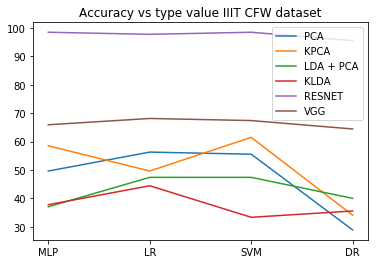

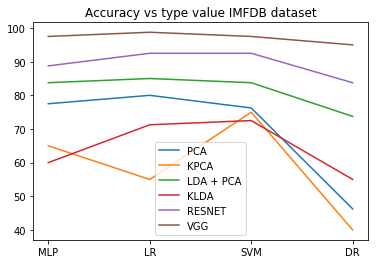

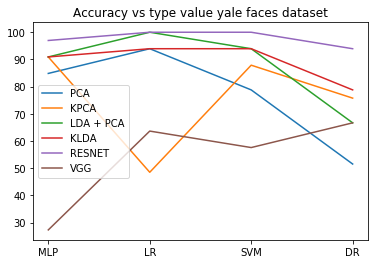

In [23]:
from tabulate import tabulate
import pandas as pd
import tkinter as tk
from tkinter import filedialog

print("")
print("table for IIIT CFW")
df = pd.DataFrame({'Features' : ['PCA+MLP','PCA+LR','PCA+SVM','PCA+DT','KPCA+MLP','KPCA+LR','KPCA+SVM','KPCA+DT','LDA+PCA+MLP','LDA+PCA+LR','LDA+PCA+SVM','LDA+PCA+DT','KLDA+MLP','KLDA+LR','KLDA+SVM','KLDA+DT','RESNET+MLP','RESNET+LR','RESNET+SVM','RESNET+DT','VGG+MLP','VGG+LR','VGG+SVM','VGG+DT'],                               
                   'red dim':[d1[0],d1[1],d1[2],d1[3],d1[12],d1[13],d1[14],d1[15],d1[24],d1[25],d1[26],d1[27],d1[36],d1[37],d1[38],d1[39],d1[48],d1[49],d1[50],d1[51],d1[60],d1[61],d1[62],d1[63]],
                   'f1 Score':[e1[0],e1[1],e1[2],e1[3],e1[12],e1[13],e1[14],e1[15],e1[24],e1[25],e1[26],e1[27],e1[36],e1[37],e1[38],e1[39],e1[48],e1[49],e1[50],e1[51],e1[60],e1[61],e1[62],e1[63]],
                   'accuracy':[a1[0],a1[1],a1[2],a1[3],a1[12],a1[13],a1[14],a1[15],a1[24],a1[25],a1[26],a1[27],a1[36],a1[37],a1[38],a1[39],a1[48],a1[49],a1[50],a1[51],a1[60],a1[61],a1[62],a1[63]],
                   'error':[r1[0],r1[1],r1[2],r1[3],r1[12],r1[13],r1[14],r1[15],r1[24],r1[25],r1[26],r1[27],r1[36],r1[37],r1[38],r1[39],r1[48],r1[49],r1[50],r1[51],r1[60],r1[61],r1[62],r1[63]]                        
                  })
print(tabulate(df, headers='keys', tablefmt='psql'))
df.to_csv(r'IIITCFW.csv')

print("")
print("table for IMFDB")
df1 = pd.DataFrame({'Features' : ['PCA+MLP','PCA+LR','PCA+SVM','PCA+DT','KPCA+MLP','KPCA+LR','KPCA+SVM','KPCA+DT','LDA+PCA+MLP','LDA+PCA+LR','LDA+PCA+SVM','LDA+PCA+DT','KLDA+MLP','KLDA+LR','KLDA+SVM','KLDA+DT','RESNET+MLP','RESNET+LR','RESNET+SVM','RESNET+DT','VGG+MLP','VGG+LR','VGG+SVM','VGG+DT'],                               
                   'red dim':[d1[4],d1[5],d1[6],d1[7],d1[16],d1[17],d1[18],d1[19],d1[28],d1[29],d1[30],d1[31],d1[40],d1[41],d1[42],d1[43],d1[52],d1[53],d1[54],d1[55],d1[64],d1[65],d1[66],d1[67]],
                   'f1 Score':[e1[4],e1[5],e1[6],e1[7],e1[16],e1[17],e1[18],e1[19],e1[28],e1[29],e1[30],e1[31],e1[40],e1[41],e1[42],e1[43],e1[52],e1[53],e1[54],e1[55],e1[64],e1[65],e1[66],e1[67]],
                   'accuracy':[a1[4],a1[5],a1[6],a1[7],a1[16],a1[17],a1[18],a1[19],a1[28],a1[29],a1[30],a1[31],a1[40],a1[41],a1[42],a1[43],a1[52],a1[53],a1[54],a1[55],a1[64],a1[65],a1[66],a1[67]],
                   'error':[r1[4],r1[5],r1[6],r1[7],r1[16],r1[17],r1[18],r1[19],r1[28],r1[29],r1[30],r1[31],r1[40],r1[41],r1[42],r1[43],r1[52],r1[53],r1[54],r1[55],r1[64],r1[65],r1[66],r1[67]]
                   })
print(tabulate(df1, headers='keys', tablefmt='psql'))
df1.to_csv(r'IMFDB.csv')

print("")
print("table for yale face database")
df2 = pd.DataFrame({'Features' : ['PCA+MLP','PCA+LR','PCA+SVM','PCA+DT','KPCA+MLP','KPCA+LR','KPCA+SVM','KPCA+DT','LDA+PCA+MLP','LDA+PCA+LR','LDA+PCA+SVM','LDA+PCA+DT','KLDA+MLP','KLDA+LR','KLDA+SVM','KLDA+DT','RESNET+MLP','RESNET+LR','RESNET+SVM','RESNET+DT','VGG+MLP','VGG+LR','VGG+SVM','VGG+DT'],                               
                   'red dim':[d1[8],d1[9],d1[10],d1[11],d1[20],d1[21],d1[22],d1[23],d1[32],d1[33],d1[34],d1[35],d1[44],d1[45],d1[46],d1[47],d1[56],d1[57],d1[58],d1[59],d1[68],d1[69],d1[70],d1[71]],
                   'f1 Score':[e1[8],e1[9],e1[10],e1[11],e1[20],e1[21],e1[22],e1[23],e1[32],e1[33],e1[34],e1[35],e1[44],e1[45],e1[46],e1[47],e1[56],e1[57],e1[58],e1[59],e1[68],e1[69],e1[70],e1[71]],
                   'accuracy':[a1[8],a1[9],a1[10],a1[11],a1[20],a1[21],a1[22],a1[23],a1[32],a1[33],a1[34],a1[35],a1[44],a1[45],a1[46],a1[47],a1[56],a1[57],a1[58],a1[59],a1[68],a1[69],a1[70],a1[71]],
                   'error':[r1[8],r1[9],r1[10],r1[11],r1[20],r1[21],r1[22],r1[23],r1[32],r1[33],r1[34],r1[35],r1[44],r1[45],r1[46],r1[47],r1[56],r1[57],r1[58],r1[59],r1[68],r1[69],r1[70],r1[71]]
                   })
print(tabulate(df2, headers='keys', tablefmt='psql'))
df2.to_csv(r'yale.csv')


# Plots for the 3 data sets
plt.title("Accuracy vs type value IIIT CFW dataset")
plt.plot(['MLP','LR','SVM','DR'],[a1[0],a1[1],a1[2],a1[3]],label='PCA')
plt.plot(['MLP','LR','SVM','DR'],[a1[12],a1[13],a1[14],a1[15]],label='KPCA')
plt.plot(['MLP','LR','SVM','DR'],[a1[24],a1[25],a1[26],a1[27]],label='LDA + PCA')
plt.plot(['MLP','LR','SVM','DR'],[a1[36],a1[37],a1[38],a1[39]],label='KLDA')
plt.plot(['MLP','LR','SVM','DR'],[a1[48],a1[49],a1[50],a1[51]],label='RESNET')
plt.plot(['MLP','LR','SVM','DR'],[a1[60],a1[61],a1[62],a1[63]],label='VGG')
plt.legend()
plt.show()

plt.title("Accuracy vs type value IMFDB dataset")
plt.plot(['MLP','LR','SVM','DR'],[a1[4],a1[5],a1[6],a1[7]],label='PCA')
plt.plot(['MLP','LR','SVM','DR'],[a1[16],a1[17],a1[18],a1[19]],label='KPCA')
plt.plot(['MLP','LR','SVM','DR'],[a1[28],a1[29],a1[30],a1[31]],label='LDA + PCA')
plt.plot(['MLP','LR','SVM','DR'],[a1[40],a1[41],a1[42],a1[43]],label='KLDA')
plt.plot(['MLP','LR','SVM','DR'],[a1[64],a1[65],a1[66],a1[67]],label='RESNET')
plt.plot(['MLP','LR','SVM','DR'],[a1[52],a1[53],a1[54],a1[55]],label='VGG')
plt.legend()
plt.show()

     
plt.title("Accuracy vs type value yale faces dataset")
plt.plot(['MLP','LR','SVM','DR'],[a1[8],a1[9],a1[10],a1[11]],label='PCA')
plt.plot(['MLP','LR','SVM','DR'],[a1[20],a1[21],a1[22],a1[23]],label='KPCA')
plt.plot(['MLP','LR','SVM','DR'],[a1[32],a1[33],a1[34],a1[35]],label='LDA + PCA')
plt.plot(['MLP','LR','SVM','DR'],[a1[44],a1[45],a1[46],a1[47]],label='KLDA')
plt.plot(['MLP','LR','SVM','DR'],[a1[56],a1[57],a1[58],a1[59]],label='RESNET')
plt.plot(['MLP','LR','SVM','DR'],[a1[68],a1[69],a1[70],a1[71]],label='VGG')
plt.legend()
plt.show()
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Print the table. (You can use Pandas)


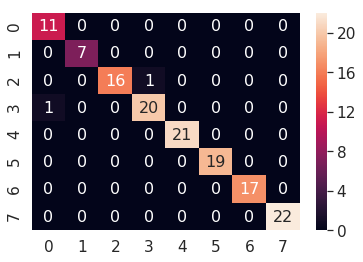

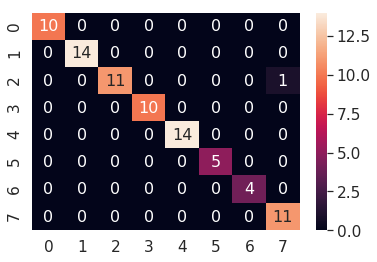

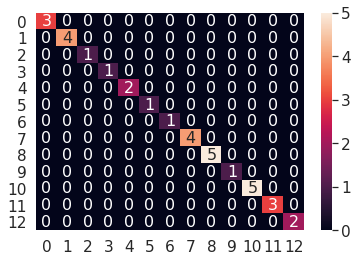

In [24]:
# For each dataset print the confusion matrix for the best model 
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import math

ha1=[a1[0],a1[1],a1[2],a1[3],a1[12],a1[13],a1[14],a1[15],a1[24],a1[25],a1[26],a1[27],a1[36],a1[37],a1[38],a1[39],a1[48],a1[49],a1[50],a1[51],a1[60],a1[61],a1[62],a1[63]]
har1 = [0,1,2,3,12,13,14,15,24,25,26,27,36,37,38,39,48,49,50,51,60,61,62,63]
max=0
temp=0
for i in range(0,24):
    if(ha1[i]>max):
        max=ha1[i]
        temp=har1[i]

df_cm = pd.DataFrame(cf[temp], range(8),
                  range(8))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

plt.show()

ha2=[a1[4],a1[5],a1[6],a1[7],a1[16],a1[17],a1[18],a1[19],a1[28],a1[29],a1[30],a1[31],a1[40],a1[41],a1[42],a1[43],a1[52],a1[53],a1[54],a1[55],a1[64],a1[65],a1[66],a1[67]]
har2 = [4,5,6,7,16,17,18,19,28,29,30,31,40,41,42,43,52,53,54,55,64,65,66,67]
max=0
temp=0
for i in range(0,24):
    if(ha2[i]>max):
        max=ha2[i]
        temp=har2[i]

df_cm = pd.DataFrame(cf[temp], range(8),
                  range(8))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

plt.show()

ha3=[a1[8],a1[9],a1[10],a1[11],a1[20],a1[21],a1[22],a1[23],a1[32],a1[33],a1[34],a1[35],a1[44],a1[45],a1[46],a1[47],a1[56],a1[57],a1[58],a1[59],a1[68],a1[69],a1[70],a1[71]]
har3 = [8,9,10,11,20,21,22,23,32,33,34,35,44,45,46,47,56,57,58,59,68,69,70,71]
max=0
temp=0
for i in range(0,24):
    if(ha3[i]>max):
        max=ha3[i]
        temp=har3[i]
        
# print(u)
# print(uu)
u, indices = np.unique(y2, return_inverse=True)
uu = int(math.sqrt(cf[temp].size))
df_cm = pd.DataFrame(cf[temp], range(uu),
                  range(uu))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

plt.show()

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

Explanation in my report and all plots here.
Note : only a small subset of these plots are shown in my report


Visualization of data in IIIT CFW


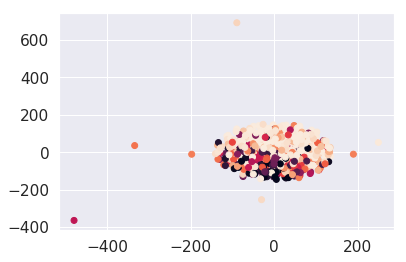

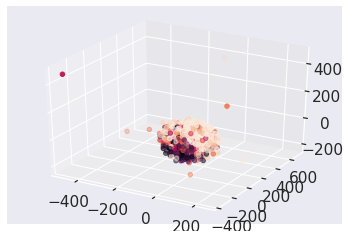


Visualization of data in IMFDB


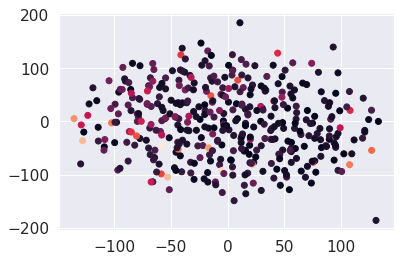

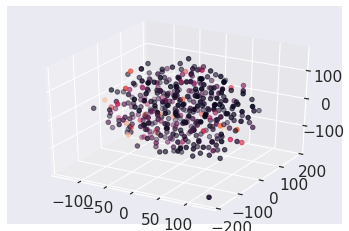


Visualization of data in yale face dataset


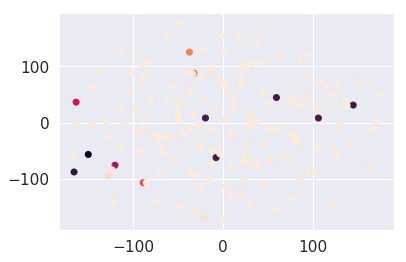

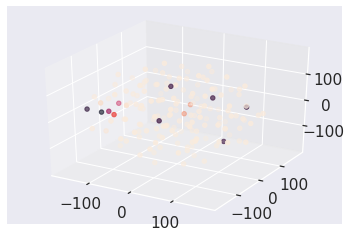


Visualization of data combined


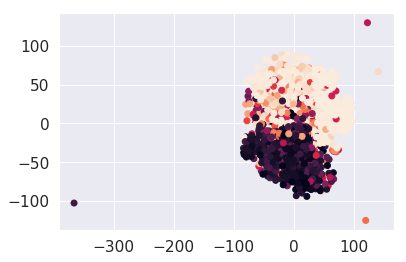

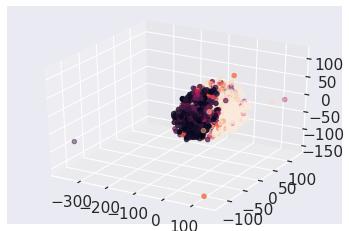


Visualization of data in IIIT CFW after PCA


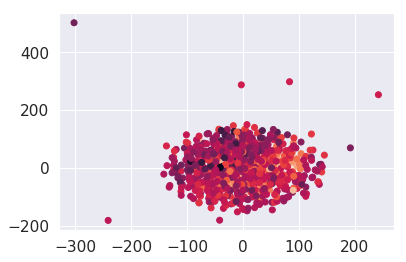


Visualization of data in IMFDB after PCA


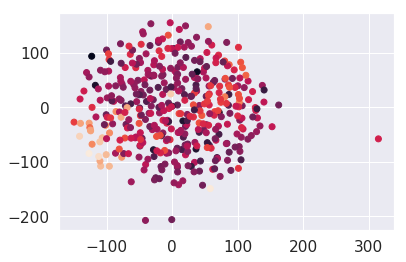


Visualization of data in yale face dataset after PCA


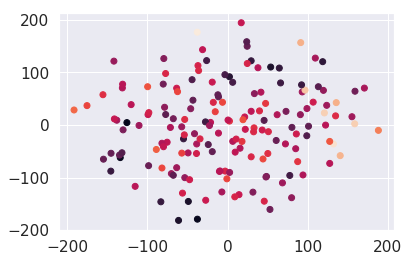


Visualization of data in combined dataset after PCA


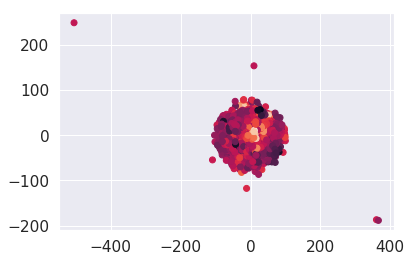


Visualization of data in IIIT CFW after LDA


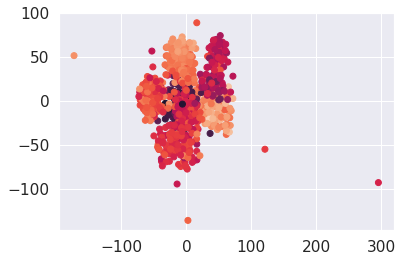


Visualization of data in IMFDB after LDA


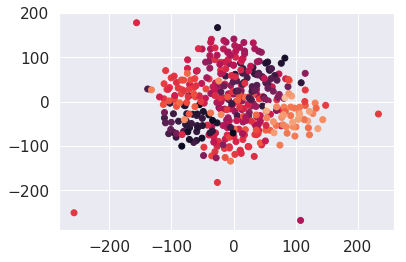


Visualization of data in yale face dataset after LDA


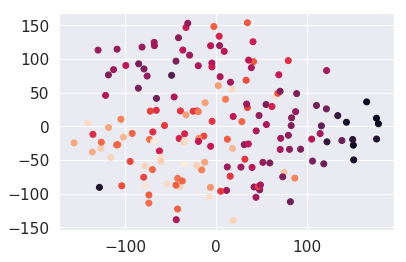


Visualization of data in combined dataset after LDA


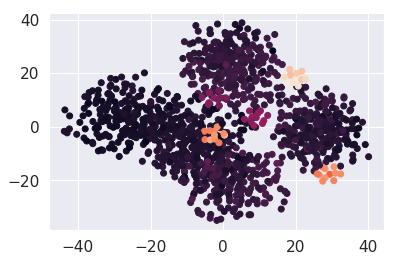


Visualization of data in IIIT CFW after KLDA


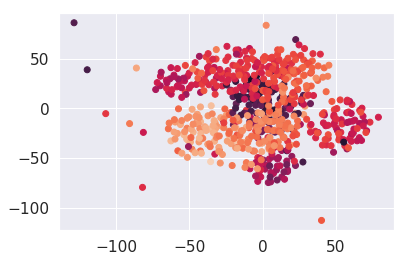


Visualization of data in IMFDB after KLDA


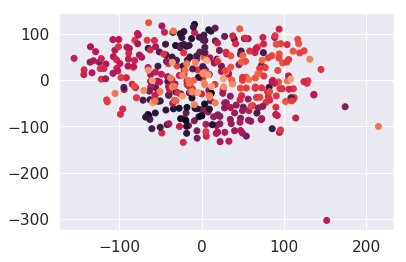


Visualization of data in yale face dataset after KLDA


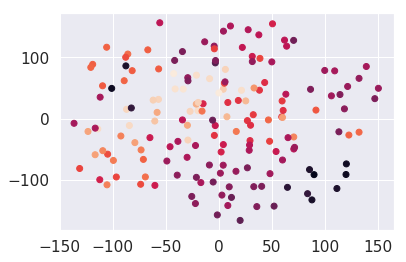


Visualization of data in combined dataset after KLDA


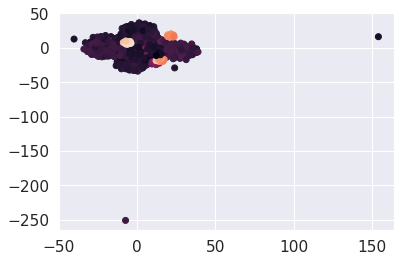

In [25]:
# Compute TSNE for different features and create a scatter plot

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
print("")
print("Visualization of data in IIIT CFW")
Xn = X
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*X_TSNE), c=Xn[:,2])
plt.show()

print("")
print("Visualization of data in IMFDB")
Xn = X1
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*X_TSNE), c=Xn[:,2])
plt.show()

print("")
print("Visualization of data in yale face dataset")
Xn = X2
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*X_TSNE), c=Xn[:,2])
plt.show()

print("")
print("Visualization of data combined")
Xall = np.concatenate([X,X1,X2])
yall = np.concatenate([y,y1,y2])
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xall)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xall[:,2])
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*X_TSNE), c=Xall[:,2])
plt.show()

print("")
print("Visualization of data in IIIT CFW after PCA")
Xn,asdf = get_pca(X,310) 
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()

print("")
print("Visualization of data in IMFDB after PCA")
Xn,asd = get_pca(X1,120)
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()


print("")
print("Visualization of data in yale face dataset after PCA")
Xn,asd = get_pca(X2,60)
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()

print("")
print("Visualization of data in combined dataset after PCA")
Xn,asd = get_pca(Xall,360)
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()


print("")
print("Visualization of data in IIIT CFW after LDA")
Xn,asd = get_lda(X,y,310)
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()


print("")
print("Visualization of data in IMFDB after LDA")
Xn,asd = get_lda(X1,y1,120)
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()


print("")
print("Visualization of data in yale face dataset after LDA")
Xn,asd = get_lda(X2,y2,60)
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()

print("")
print("Visualization of data in combined dataset after LDA")
Xn,asd = get_lda(Xall,yall,360)
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()

print("")
print("Visualization of data in IIIT CFW after KLDA")
Xn,asd = get_kernel_lda(X,y,310)
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()


print("")
print("Visualization of data in IMFDB after KLDA")
Xn,asd = get_kernel_lda(X1,y1,120)
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()


print("")
print("Visualization of data in yale face dataset after KLDA")
Xn,asd = get_kernel_lda(X2,y2,60)
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()

print("")
print("Visualization of data in combined dataset after KLDA")
Xn,asd = get_kernel_lda(Xall,yall,360)
k = 3 
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()



4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

Given a pair of face image and an arbitrary class ID. We can perform KNN on the image
using the complete dataset. If the majority of the k-nearest neighbors of the image have the same class ID, the response is a “Yes” otherwise its a “No”.
This is how we can formulate KNN classifier on the 3 datasets.
We first extract the features(using
PCA, LDA, or other variants), and train a KNN clas-
sifier. Then, given a data point X and the correspond-
ing class ID, we find the predicted ID.

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

\begin{equation}
Accuracy = \frac{correct predictions}{total predictions} 
\end{equation}

\begin{equation}
Precision = \frac{true positive}{true positive + false positive} 
\end{equation}

\begin{equation}
Recall = \frac{true positive}{true positive + false negetive}  
\end{equation}

\begin{equation}
F1 score = \frac{2*precision*recall}{precision+recall}
\end{equation}

We can also use k fold cross validation error and confusion matrix to analyze performances.

4(c)Show empirical re-sults  with  all  the  representations

We used different features and combined them with different k values in the KNN classifier to see which gave the best accuracy.
Csv files have been attached in my project submission folder tabulating all the accuracy's and results.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score

a1=[]
e1=[]
r1=[]
d1=[]

class FaceVerification():
    def __init__(self,X_train,X_validate,y_train,y_validate):
        self.X_train = X_train
        self.X_validate = X_validate
        self.y_train = y_train
        self.y_validate = y_validate
        
    def train_and_test3(self,X_train,y_train):
        d1.append(X_train.shape[1])
        
        neigh = KNeighborsClassifier(n_neighbors=3)
        neigh.fit(X_train, y_train)
        pred=neigh.predict(self.X_validate)
        print(neigh.score(self.X_validate,self.y_validate)*100)
        a1.append(neigh.score(self.X_validate,self.y_validate)*100)
        e1.append(precision_score(self.y_validate,pred,average='weighted'))
        r1.append(100-(neigh.score(self.X_validate,self.y_validate)*100))
        
        
    def train_and_test5(self,X_train,y_train):
        d1.append(X_train.shape[1])
        
        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(X_train, y_train)
        neigh.predict(self.X_validate)
        pred=neigh.predict(self.X_validate)
        print(neigh.score(self.X_validate,self.y_validate)*100)
        a1.append(neigh.score(self.X_validate,self.y_validate)*100)
        e1.append(precision_score(self.y_validate,pred,average='weighted'))
        r1.append(100-(neigh.score(self.X_validate,self.y_validate)*100))
        
    def train_and_test7(self,X_train,y_train):
        d1.append(X_train.shape[1])
        
        neigh = KNeighborsClassifier(n_neighbors=69)
        neigh.fit(X_train, y_train)
        neigh.predict(self.X_validate)
        pred=neigh.predict(self.X_validate)
        print(neigh.score(self.X_validate,self.y_validate)*100)
        a1.append(neigh.score(self.X_validate,self.y_validate)*100)
        e1.append(precision_score(self.y_validate,pred,average='weighted'))
        r1.append(100-(neigh.score(self.X_validate,self.y_validate)*100))
        
    def train_and_test9(self,X_train,y_train):
        d1.append(X_train.shape[1])
        
        neigh = KNeighborsClassifier(n_neighbors=99)
        neigh.fit(X_train, y_train)
        neigh.predict(self.X_validate)
        pred=neigh.predict(self.X_validate)
        print(neigh.score(self.X_validate,self.y_validate)*100)
        a1.append(neigh.score(self.X_validate,self.y_validate)*100)
        e1.append(precision_score(self.y_validate,pred,average='weighted'))
        r1.append(100-(neigh.score(self.X_validate,self.y_validate)*100))

In [27]:
# Create a train and validation split to train your classifier 

from sklearn.model_selection import train_test_split
print("Printing accuracies to find the best feature KNN classifier model")
print("Displaying accuracies dataset wise for k values of 3 5 7 9")
print("PCA")
X_train,X_validate,y_train,y_validate=train_test_split(X,y,test_size=0.2)
X_3D,pca = get_pca(X_train,310)
X_validate=pca.transform(X_validate)
a=X_validate
print("IIIT CFT")
classifier = FaceVerification(X_3D,X_validate,y_train,y_validate)
classifier.train_and_test3(X_3D,y_train)
classifier.train_and_test5(X_3D,y_train)
classifier.train_and_test7(X_3D,y_train)
classifier.train_and_test9(X_3D,y_train)

X1_train,X1_validate,y1_train,y1_validate=train_test_split(X1,y1,test_size=0.2)
X1_3D,pca = get_pca(X1_train,120)
X1_validate=pca.transform(X1_validate)
b=X1_validate
print("IMFDB")
classifier1 = FaceVerification(X1_3D,X1_validate,y1_train,y1_validate)
classifier1.train_and_test3(X1_3D,y1_train)
classifier1.train_and_test5(X1_3D,y1_train)
classifier1.train_and_test7(X1_3D,y1_train)
classifier1.train_and_test9(X1_3D,y1_train)

X2_train,X2_validate,y2_train,y2_validate=train_test_split(X2,y2,test_size=0.2)
X2_3D,pca = get_pca(X2_train,60)
X2_validate=pca.transform(X2_validate)
c=X2_validate
print("Yale Face Database")
classifier2 = FaceVerification(X2_3D,X2_validate,y2_train,y2_validate)
classifier2.train_and_test3(X2_3D,y2_train)
classifier2.train_and_test5(X2_3D,y2_train)
classifier2.train_and_test7(X2_3D,y2_train)
classifier2.train_and_test9(X2_3D,y2_train)


print(" ")
print("KPCA")
X_train,X_validate,y_train,y_validate,X1_train,X1_validate,y1_train,y1_validate,X2_train,X2_validate,y2_train,y2_validate =[],[],[],[],[],[],[],[],[],[],[],[] 
X_train,X_validate,y_train,y_validate=train_test_split(X,y,test_size=0.2)
X_3D_1,kpca = get_kernel_pca(X_train,310)
X_validate = kpca.transform(X_validate)
print("IIIT CFT")
classifier = FaceVerification(X_3D_1,X_validate,y_train,y_validate)
classifier.train_and_test3(X_3D_1,y_train)
classifier.train_and_test5(X_3D_1,y_train)
classifier.train_and_test7(X_3D_1,y_train)
classifier.train_and_test9(X_3D_1,y_train)

X1_train,X1_validate,y1_train,y1_validate=train_test_split(X1,y1,test_size=0.2)
X1_3D_1,kpca = get_kernel_pca(X1_train,120)
X1_validate = kpca.transform(X1_validate)
print("IMFDB")
classifier1 = FaceVerification(X1_3D_1,X1_validate,y1_train,y1_validate)
classifier1.train_and_test3(X1_3D_1,y1_train)
classifier1.train_and_test5(X1_3D_1,y1_train)
classifier1.train_and_test7(X1_3D_1,y1_train)
classifier1.train_and_test9(X1_3D_1,y1_train)

X2_train,X2_validate,y2_train,y2_validate=train_test_split(X2,y2,test_size=0.2)
X2_3D_1,kpca = get_kernel_pca(X2_train,60)
X2_validate = kpca.transform(X2_validate)
print("Yale Face Database")
classifier2 = FaceVerification(X2_3D_1,X2_validate,y2_train,y2_validate)
classifier2.train_and_test3(X2_3D_1,y2_train)
classifier2.train_and_test5(X2_3D_1,y2_train)
classifier2.train_and_test7(X2_3D_1,y2_train)
classifier2.train_and_test9(X2_3D_1,y2_train)


print(" ")
print("PCA+LDA")
X_train,X_validate,y_train,y_validate,X1_train,X1_validate,y1_train,y1_validate,X2_train,X2_validate,y2_train,y2_validate =[],[],[],[],[],[],[],[],[],[],[],[] 

X_train,X_validate,y_train,y_validate=train_test_split(X,y,test_size=0.2)
X_3D,pca = get_pca(X_train,310)
X_validate=pca.transform(X_validate)
X_3D_2,lda = get_lda(X_3D,y_train,310)
X_validate=lda.transform(X_validate)
print("IIIT CFT")
classifier = FaceVerification(X_3D_2,X_validate,y_train,y_validate)
classifier.train_and_test3(X_3D_2,y_train)
classifier.train_and_test5(X_3D_2,y_train)
classifier.train_and_test7(X_3D_2,y_train)
classifier.train_and_test9(X_3D_2,y_train)

X1_train,X1_validate,y1_train,y1_validate=train_test_split(X1,y1,test_size=0.2)
X1_3D,pca = get_pca(X1_train,120)
X1_validate=pca.transform(X1_validate)
X1_3D_2,lda = get_lda(X1_3D,y1_train,120)
X1_validate=lda.transform(X1_validate)
print("IMFDB")
classifier1 = FaceVerification(X1_3D_2,X1_validate,y1_train,y1_validate)
classifier1.train_and_test3(X1_3D_2,y1_train)
classifier1.train_and_test5(X1_3D_2,y1_train)
classifier1.train_and_test7(X1_3D_2,y1_train)
classifier1.train_and_test9(X1_3D_2,y1_train)

X2_train,X2_validate,y2_train,y2_validate=train_test_split(X2,y2,test_size=0.2)
X2_3D,pca = get_pca(X2_train,60)
X2_validate=pca.transform(X2_validate)
X2_3D_2,lda = get_lda(X2_3D,y2_train,60)
X2_validate=lda.transform(X2_validate)
print("Yale Face Database")
classifier2 = FaceVerification(X2_3D_2,X2_validate,y2_train,y2_validate)
classifier2.train_and_test3(X2_3D_2,y2_train)
classifier2.train_and_test5(X2_3D_2,y2_train)
classifier2.train_and_test7(X2_3D_2,y2_train)
classifier2.train_and_test9(X2_3D_2,y2_train)

print(" ")
print("KLDA")
X_train,X_validate,y_train,y_validate,X1_train,X1_validate,y1_train,y1_validate,X2_train,X2_validate,y2_train,y2_validate =[],[],[],[],[],[],[],[],[],[],[],[] 

X_train,X_validate,y_train,y_validate=train_test_split(X,y,test_size=0.2)
X_3D_3,klda = get_kernel_lda(X_train,y_train,310)
X_validate=klda.transform(X_validate)
print("IIIT CFT")
classifier = FaceVerification(X_3D_3,X_validate,y_train,y_validate)
classifier.train_and_test3(X_3D_3,y_train)
classifier.train_and_test5(X_3D_3,y_train)
classifier.train_and_test7(X_3D_3,y_train)
classifier.train_and_test9(X_3D_3,y_train)

X1_train,X1_validate,y1_train,y1_validate=train_test_split(X1,y1,test_size=0.2)
X1_3D_3,klda = get_kernel_lda(X1_train,y1_train,120)
X1_validate=klda.transform(X1_validate)
print("IMFDB")
classifier1 = FaceVerification(X1_3D_3,X1_validate,y1_train,y1_validate)
classifier1.train_and_test3(X1_3D_3,y1_train)
classifier1.train_and_test5(X1_3D_3,y1_train)
classifier1.train_and_test7(X1_3D_3,y1_train)
classifier1.train_and_test9(X1_3D_3,y1_train)

X2_train,X2_validate,y2_train,y2_validate=train_test_split(X2,y2,test_size=0.2)
X2_3D_3,klda = get_kernel_lda(X2_train,y2_train,60)
X2_validate=klda.transform(X2_validate)
print("Yale Face Database")
classifier2 = FaceVerification(X2_3D_3,X2_validate,y2_train,y2_validate)
classifier2.train_and_test3(X2_3D_3,y2_train)
classifier2.train_and_test5(X2_3D_3,y2_train)
classifier2.train_and_test7(X2_3D_3,y2_train)
classifier2.train_and_test9(X2_3D_3,y2_train)

print(" ")
print("RESNET")
X_train,X_validate,y_train,y_validate,X1_train,X1_validate,y1_train,y1_validate,X2_train,X2_validate,y2_train,y2_validate =[],[],[],[],[],[],[],[],[],[],[],[] 
X_3D_5 = get_resnet_features(dirpath)
X1_3D_5 = get_resnet_features(dirpath1)
X2_3D_5 = get_resnet_features(dirpath2)

X_train,X_validate,y_train,y_validate=train_test_split(X_3D_5,y,test_size=0.2)
print("IIIT CFT")
classifier = FaceVerification(X_train,X_validate,y_train,y_validate)
classifier.train_and_test3(X_train,y_train)
classifier.train_and_test5(X_train,y_train)
classifier.train_and_test7(X_train,y_train)
classifier.train_and_test9(X_train,y_train)

X1_train,X1_validate,y1_train,y1_validate=train_test_split(X1_3D_5,y1,test_size=0.2)
print("IMFDB")
classifier1 = FaceVerification(X1_train,X1_validate,y1_train,y1_validate)
classifier1.train_and_test3(X1_train,y1_train)
classifier1.train_and_test5(X1_train,y1_train)
classifier1.train_and_test7(X1_train,y1_train)
classifier1.train_and_test9(X1_train,y1_train)

X2_train,X2_validate,y2_train,y2_validate=train_test_split(X2_3D_5,y2,test_size=0.2)
print("Yale Face Database")
classifier2 = FaceVerification(X2_train,X2_validate,y2_train,y2_validate)
classifier2.train_and_test3(X2_train,y2_train)
classifier2.train_and_test5(X2_train,y2_train)
classifier2.train_and_test7(X2_train,y2_train)
classifier2.train_and_test9(X2_train,y2_train)

print(" ")
print("VGG")
X_train,X_validate,y_train,y_validate,X1_train,X1_validate,y1_train,y1_validate,X2_train,X2_validate,y2_train,y2_validate =[],[],[],[],[],[],[],[],[],[],[],[] 
X_3D_4 = get_vgg_features(dirpath)
X1_3D_4 = get_vgg_features(dirpath1)
X2_3D_4 = get_vgg_features(dirpath2)

X_train,X_validate,y_train,y_validate=train_test_split(X_3D_4,y,test_size=0.2)
print("IIIT CFT")
classifier = FaceVerification(X_train,X_validate,y_train,y_validate)
classifier.train_and_test3(X_train,y_train)
classifier.train_and_test5(X_train,y_train)
classifier.train_and_test7(X_train,y_train)
classifier.train_and_test9(X_train,y_train)

X1_train,X1_validate,y1_train,y1_validate=train_test_split(X1_3D_4,y1,test_size=0.2)
print("IMFDB")
classifier1 = FaceVerification(X1_train,X1_validate,y1_train,y1_validate)
classifier1.train_and_test3(X1_train,y1_train)
classifier1.train_and_test5(X1_train,y1_train)
classifier1.train_and_test7(X1_train,y1_train)
classifier1.train_and_test9(X1_train,y1_train)

X2_train,X2_validate,y2_train,y2_validate=train_test_split(X2_3D_4,y2,test_size=0.2)
print("Yale Face Database")
classifier2 = FaceVerification(X2_train,X2_validate,y2_train,y2_validate)
classifier2.train_and_test3(X2_train,y2_train)
classifier2.train_and_test5(X2_train,y2_train)
classifier2.train_and_test7(X2_train,y2_train)
classifier2.train_and_test9(X2_train,y2_train)



Printing accuracies to find the best feature KNN classifier model
Displaying accuracies dataset wise for k values of 3 5 7 9
PCA
IIIT CFT
34.81481481481482
37.77777777777778
37.03703703703704
38.51851851851852
IMFDB
58.75
61.25000000000001
28.749999999999996
27.500000000000004
Yale Face Database
84.84848484848484
81.81818181818183
9.090909090909092
6.0606060606060606
 
KPCA
IIIT CFT
28.14814814814815
34.074074074074076
31.11111111111111
31.851851851851855
IMFDB
63.74999999999999
57.49999999999999
33.75
32.5
Yale Face Database
81.81818181818183
81.81818181818183
15.151515151515152
3.0303030303030303
 
PCA+LDA
IIIT CFT
51.11111111111111
50.37037037037037
48.148148148148145
46.666666666666664
IMFDB
81.25
81.25
80.0
78.75
Yale Face Database
100.0
100.0
12.121212121212121
6.0606060606060606
 
KLDA
IIIT CFT
40.74074074074074
39.25925925925926
42.22222222222222
43.7037037037037
IMFDB
72.5
81.25
78.75
68.75
Yale Face Database
96.96969696969697
93.93939393939394
12.121212121212121
6.06060606060


table for IIIT CFW
+----+--------------+------------+-------------+-----------+----------------------+
|    | Features     |   accuracy |   precision |   red dim |   verification error |
|----+--------------+------------+-------------+-----------+----------------------|
|  0 | PCA k=3      |    34.8148 |    0.478716 |       310 |             65.1852  |
|  1 | PCA k=5      |    37.7778 |    0.524191 |       310 |             62.2222  |
|  2 | PCA k=69     |    37.037  |    0.577938 |       310 |             62.963   |
|  3 | PCA k=99     |    38.5185 |    0.616215 |       310 |             61.4815  |
|  4 | KPCA k=3     |    28.1481 |    0.468111 |       310 |             71.8519  |
|  5 | KPCA k=5     |    34.0741 |    0.618944 |       310 |             65.9259  |
|  6 | KPCA k=69    |    31.1111 |    0.544678 |       310 |             68.8889  |
|  7 | KPCA k=99    |    31.8519 |    0.43972  |       310 |             68.1481  |
|  8 | LDA+PCA k=3  |    51.1111 |    0.55015  |        

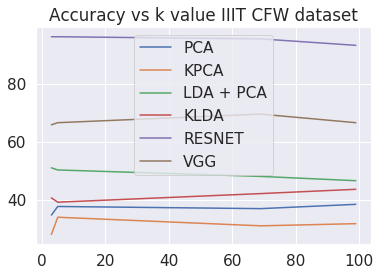

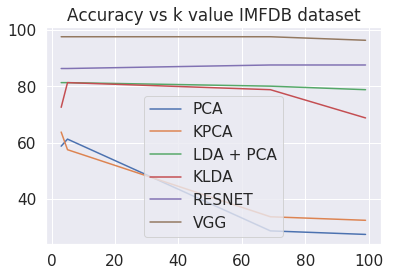

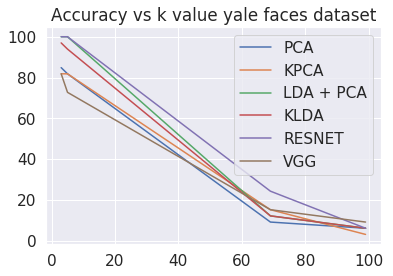

In [28]:
from tabulate import tabulate
import pandas as pd

print("")
print("table for IIIT CFW")
df = pd.DataFrame({'Features' : ['PCA k=3','PCA k=5','PCA k=69','PCA k=99','KPCA k=3','KPCA k=5','KPCA k=69','KPCA k=99','LDA+PCA k=3','LDA+PCA k=5','LDA+PCA k=69','LDA+PCA k=99','KLDA k=3','KLDA k=5','KLDA k=69','KLDA k=99','RESNET k=3','RESNET k=5','RESNET k=69','RESNET k=99','VGG k=3','VGG k=5','VGG k=69','VGG k=99'],                               
                   'red dim':[d1[0],d1[1],d1[2],d1[3],d1[12],d1[13],d1[14],d1[15],d1[24],d1[25],d1[26],d1[27],d1[36],d1[37],d1[38],d1[39],d1[48],d1[49],d1[50],d1[51],d1[60],d1[61],d1[62],d1[63]],
                   'precision':[e1[0],e1[1],e1[2],e1[3],e1[12],e1[13],e1[14],e1[15],e1[24],e1[25],e1[26],e1[27],e1[36],e1[37],e1[38],e1[39],e1[48],e1[49],e1[50],e1[51],e1[60],e1[61],e1[62],e1[63]],
                   'accuracy':[a1[0],a1[1],a1[2],a1[3],a1[12],a1[13],a1[14],a1[15],a1[24],a1[25],a1[26],a1[27],a1[36],a1[37],a1[38],a1[39],a1[48],a1[49],a1[50],a1[51],a1[60],a1[61],a1[62],a1[63]],
                   'verification error':[r1[0],r1[1],r1[2],r1[3],r1[12],r1[13],r1[14],r1[15],r1[24],r1[25],r1[26],r1[27],r1[36],r1[37],r1[38],r1[39],r1[48],r1[49],r1[50],r1[51],r1[60],r1[61],r1[62],r1[63]]                        
                  })
print(tabulate(df, headers='keys', tablefmt='psql'))
df.to_csv(r'IIITCFWKNN.csv')

print("")
print("table for IMFDB")
df1 = pd.DataFrame({'Features' : ['PCA k=3','PCA k=5','PCA k=69','PCA k=99','KPCA k=3','KPCA k=5','KPCA k=69','KPCA k=99','LDA+PCA k=3','LDA+PCA k=5','LDA+PCA k=69','LDA+PCA k=99','KLDA k=3','KLDA k=5','KLDA k=69','KLDA k=99','RESNET k=3','RESNET k=5','RESNET k=69','RESNET k=99','VGG k=3','VGG k=5','VGG k=69','VGG k=99'],                               
                   'red dim':[d1[4],d1[5],d1[6],d1[7],d1[16],d1[17],d1[18],d1[19],d1[28],d1[29],d1[30],d1[31],d1[40],d1[41],d1[42],d1[43],d1[52],d1[53],d1[54],d1[55],d1[64],d1[65],d1[66],d1[67]],
                   'precision':[e1[4],e1[5],e1[6],e1[7],e1[16],e1[17],e1[18],e1[19],e1[28],e1[29],e1[30],e1[31],e1[40],e1[41],e1[42],e1[43],e1[52],e1[53],e1[54],e1[55],e1[64],e1[65],e1[66],e1[67]],
                   'accuracy':[a1[4],a1[5],a1[6],a1[7],a1[16],a1[17],a1[18],a1[19],a1[28],a1[29],a1[30],a1[31],a1[40],a1[41],a1[42],a1[43],a1[52],a1[53],a1[54],a1[55],a1[64],a1[65],a1[66],a1[67]],
                   'verification error':[r1[4],r1[5],r1[6],r1[7],r1[16],r1[17],r1[18],r1[19],r1[28],r1[29],r1[30],r1[31],r1[40],r1[41],r1[42],r1[43],r1[52],r1[53],r1[54],r1[55],r1[64],r1[65],r1[66],r1[67]]
                   })
print(tabulate(df1, headers='keys', tablefmt='psql'))
df1.to_csv(r'IMFDBKNN.csv')

print("")
print("table for yale face database")
df2 = pd.DataFrame({'Features' : ['PCA k=3','PCA k=5','PCA k=69','PCA k=99','KPCA k=3','KPCA k=5','KPCA k=69','KPCA k=99','LDA+PCA k=3','LDA+PCA k=5','LDA+PCA k=69','LDA+PCA k=99','KLDA k=3','KLDA k=5','KLDA k=69','KLDA k=99','RESNET k=3','RESNET k=5','RESNET k=69','RESNET k=99','VGG k=3','VGG k=5','VGG k=69','VGG k=99'],                               
                   'red dim':[d1[8],d1[9],d1[10],d1[11],d1[20],d1[21],d1[22],d1[23],d1[32],d1[33],d1[34],d1[35],d1[44],d1[45],d1[46],d1[47],d1[56],d1[57],d1[58],d1[59],d1[68],d1[69],d1[70],d1[71]],
                   'precision':[e1[8],e1[9],e1[10],e1[11],e1[20],e1[21],e1[22],e1[23],e1[32],e1[33],e1[34],e1[35],e1[44],e1[45],e1[46],e1[47],e1[56],e1[57],e1[58],e1[59],e1[68],e1[69],e1[70],e1[71]],
                   'accuracy':[a1[8],a1[9],a1[10],a1[11],a1[20],a1[21],a1[22],a1[23],a1[32],a1[33],a1[34],a1[35],a1[44],a1[45],a1[46],a1[47],a1[56],a1[57],a1[58],a1[59],a1[68],a1[69],a1[70],a1[71]],
                   'verification error':[r1[8],r1[9],r1[10],r1[11],r1[20],r1[21],r1[22],r1[23],r1[32],r1[33],r1[34],r1[35],r1[44],r1[45],r1[46],r1[47],r1[56],r1[57],r1[58],r1[59],r1[68],r1[69],r1[70],r1[71]]
                   })
print(tabulate(df2, headers='keys', tablefmt='psql'))
df2.to_csv(r'yaleKNN.csv')

# Plots for the 3 data sets
plt.title("Accuracy vs k value IIIT CFW dataset")
plt.plot([3,5,69,99],[a1[0],a1[1],a1[2],a1[3]],label='PCA')
plt.plot([3,5,69,99],[a1[12],a1[13],a1[14],a1[15]],label='KPCA')
plt.plot([3,5,69,99],[a1[24],a1[25],a1[26],a1[27]],label='LDA + PCA')
plt.plot([3,5,69,99],[a1[36],a1[37],a1[38],a1[39]],label='KLDA')
plt.plot([3,5,69,99],[a1[48],a1[49],a1[50],a1[51]],label='RESNET')
plt.plot([3,5,69,99],[a1[60],a1[61],a1[62],a1[63]],label='VGG')
plt.legend()
plt.show()

plt.title("Accuracy vs k value IMFDB dataset")
plt.plot([3,5,69,99],[a1[4],a1[5],a1[6],a1[7]],label='PCA')
plt.plot([3,5,69,99],[a1[16],a1[17],a1[18],a1[19]],label='KPCA')
plt.plot([3,5,69,99],[a1[28],a1[29],a1[30],a1[31]],label='LDA + PCA')
plt.plot([3,5,69,99],[a1[40],a1[41],a1[42],a1[43]],label='KLDA')
plt.plot([3,5,69,99],[a1[64],a1[65],a1[66],a1[67]],label='RESNET')
plt.plot([3,5,69,99],[a1[52],a1[53],a1[54],a1[55]],label='VGG')
plt.legend()
plt.show()

ha3=[a1[8],a1[9],a1[10],a1[11],a1[20],a1[21],a1[22],a1[23],a1[32],a1[33],a1[34],a1[35],a1[44],a1[45],a1[46],a1[47],a1[56],a1[57],a1[58],a1[59],a1[68],a1[69],a1[70],a1[71]]
     
plt.title("Accuracy vs k value yale faces dataset")
plt.plot([3,5,69,99],[a1[8],a1[9],a1[10],a1[11]],label='PCA')
plt.plot([3,5,69,99],[a1[20],a1[21],a1[22],a1[23]],label='KPCA')
plt.plot([3,5,69,99],[a1[32],a1[33],a1[34],a1[35]],label='LDA + PCA')
plt.plot([3,5,69,99],[a1[44],a1[45],a1[46],a1[47]],label='KLDA')
plt.plot([3,5,69,99],[a1[56],a1[57],a1[58],a1[59]],label='RESNET')
plt.plot([3,5,69,99],[a1[68],a1[69],a1[70],a1[71]],label='VGG')
plt.legend()
plt.show()

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
  
CHOSEN TOPIC
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.

The problem statement taken by me is Gender classification.
We combine the CFW and IMFDB datasets to form a new data set.
Females are in one class with label 1 and males are in another class with label 0.



You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [29]:
# Load data
Xfin = np.concatenate((X,X1))
yfin1 =[]
yfin2 =[]

for i in y:
    if i == 0 or i == 1 or i ==2 or i ==4 or i ==5 or i ==6 or i==7:
        yfin1.append(0)
    else:
        yfin1.append(1)
        
for i in y1:
    if i == 2 or i == 4 or i ==6 or i ==7:
        yfin2.append(0)
    else:
        yfin2.append(1)

yfin = np.concatenate((yfin1,yfin2))


In [30]:
# Define your features

X_train,X_validate,y_train,y_validate=train_test_split(Xfin,yfin,test_size=0.2)

trainp,pca = get_pca(X_train,200)
validatep=pca.transform(X_validate)

trainl,lda = get_lda(X_train,y_train,200)
validatel=lda.transform(X_validate)

traint,lda = get_lda(trainp,y_train,200)
validatet=lda.transform(validatep)

In [31]:
# Create your classifier

class GenderClassifier():
    def __init__(self,X_train,X_validate,y_train,y_validate):
        self.X_train = X_train
        self.X_validate = X_validate
        self.y_train = y_train
        self.y_validate = y_validate
        self.pred = []
        
    def train_and_testg(self,X_train,y_train):
        clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train,y_train)
        prediction=clf.predict(self.X_validate)
        acc=clf.score(self.X_validate,self.y_validate) 
        return acc,prediction

print("Accuracy with PCA")
classifierg = GenderClassifier(trainp,validatep,y_train,y_validate)
acc,pred=classifierg.train_and_testg(trainp,y_train)
print(acc)
print("Accuracy with LDA")
classifierg1 = GenderClassifier(trainp,validatel,y_train,y_validate)
acc,pred1=classifierg1.train_and_testg(trainl,y_train)
print(acc)
print("Accuracy with PCA+LDA")
classifierg2 = GenderClassifier(trainp,validatet,y_train,y_validate)
acc,pred2=classifierg2.train_and_testg(traint,y_train)
print(acc)

Accuracy with PCA
0.8
Accuracy with LDA
0.6976744186046512
Accuracy with PCA+LDA
0.813953488372093


k-fold validation with PCA
0.0020736058582119586
k-fold validation with LDA
0.0001892915089237422
k-fold validation with PCA+LDA
0.0013448997962051859

TSNE plots


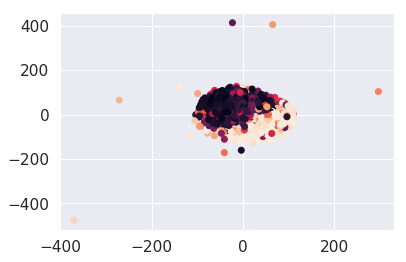

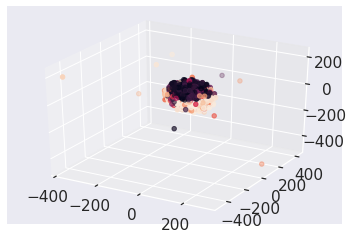


ISOMAP plots


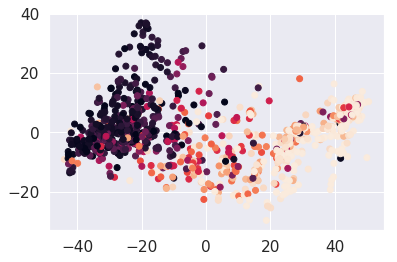

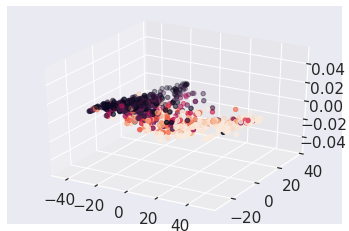


PCA plots


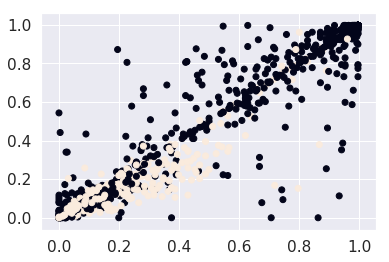

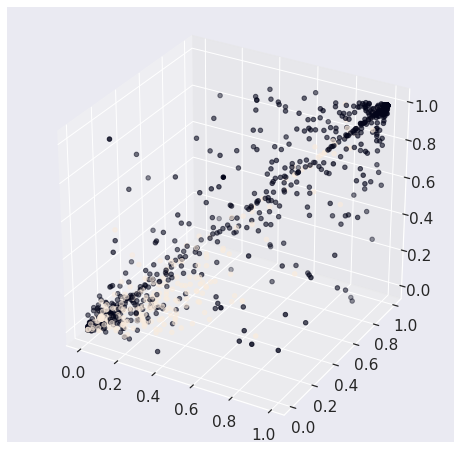

In [32]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
accuracy=[]
for train_index, test_index in kf.split(trainp):
    X_t, X_test = trainp[train_index], trainp[test_index]
    y_t, y_test = y_train[train_index], y_train[test_index]
    cg = GenderClassifier(X_t,X_test,y_t,y_test)
    accu,hjaf = cg.train_and_testg(X_t,y_t)
    accuracy.append(accu)
    
var=np.var(accuracy)
print("k-fold validation with PCA")
print(var)

accuracy=[]
for train_index, test_index in kf.split(trainl):
    X_t, X_test = trainl[train_index], trainl[test_index]
    y_t, y_test = y_train[train_index], y_train[test_index]
    cg = GenderClassifier(X_t,X_test,y_t,y_test)
    accu,hjaf = cg.train_and_testg(X_t,y_t)
    accuracy.append(accu)
    
var=np.var(accuracy)
print("k-fold validation with LDA")
print(var)

accuracy=[]
for train_index, test_index in kf.split(traint):
    X_t, X_test = traint[train_index], traint[test_index]
    y_t, y_test = y_train[train_index], y_train[test_index]
    cg = GenderClassifier(X_t,X_test,y_t,y_test)
    accu,hjaf = cg.train_and_testg(X_t,y_t)
    accuracy.append(accu)
    
var=np.var(accuracy)
print("k-fold validation with PCA+LDA")
print(var)

#------------------------------------------------------------

print("")
print("TSNE plots")
Xn = Xfin
k = 3
X_TSNE = TSNE(n_components=k).fit_transform(Xn)
plt.scatter(*zip(*X_TSNE[:,:2]), c=Xn[:,2])
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*X_TSNE), c=Xn[:,2])
plt.show()

#-------------------------------------------------------------



print("")
print("ISOMAP plots")
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(Xfin)
plt.scatter(*zip(*X_transformed[:,:2]), c=Xfin[:,2])
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*X_transformed), c=Xfin[:,2])
plt.show()

#--------------------------------------------------------------

print("")
print("PCA plots")
pca = PCA(n_components=2)
pca.fit(Xfin) 
plt.scatter(Xfin[:,0],Xfin[:,1],c=yfin)
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xfin[:,0],Xfin[:,1],Xfin[:,2],c=yfin)


Examples with PCA

Female : class 1 and Male : class 0

         Correct prediction          Wrong prediction


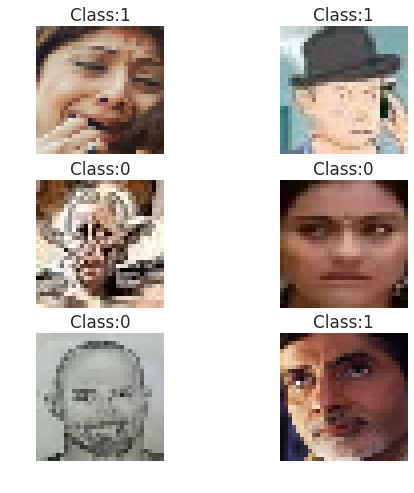

Examples with LDA

Female : class 1 and Male : class 0

         Correct prediction          Wrong prediction


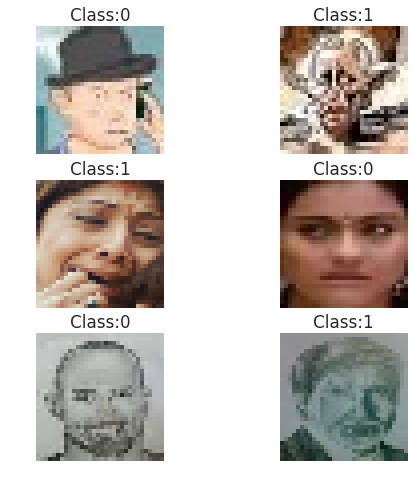

Examples with PCA+LDA

Female : class 1 and Male : class 0

         Correct prediction          Wrong prediction


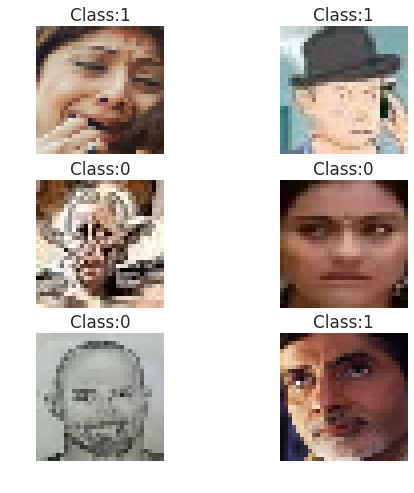

In [33]:
# Show quantitative results such as examples of correct prediction and wrong prediction
flg=0
flg1=0
crct_img=[]
wrng_img=[]
X_v=X_validate.reshape(215,32,32,3)
for i in range(y_validate.size):
    if y_validate[i] == pred[i] and flg<=3:
        crct_img.append(i) 
        flg=flg+1
    if y_validate[i] != pred[i] and flg1<=3:
        wrng_img.append(i)
        flg1=flg1+1
        
ind = [crct_img[0],wrng_img[0],crct_img[1],wrng_img[1],crct_img[2],wrng_img[2]]
print("Examples with PCA")
print("")
print("Female : class 1 and Male : class 0")
print("")
print("         Correct prediction          Wrong prediction")
disply_images(X_v[ind,...],pred[ind],row=3,col=2)


flg=0
flg1=0
crct_img=[]
wrng_img=[]
X_v=X_validate.reshape(215,32,32,3)
for i in range(y_validate.size):
    if y_validate[i] == pred1[i] and flg<=3:
        crct_img.append(i) 
        flg=flg+1
    if y_validate[i] != pred1[i] and flg1<=3:
        wrng_img.append(i)
        flg1=flg1+1
        
ind = [crct_img[0],wrng_img[0],crct_img[1],wrng_img[1],crct_img[2],wrng_img[2]]
print("Examples with LDA")
print("")
print("Female : class 1 and Male : class 0")
print("")
print("         Correct prediction          Wrong prediction")
disply_images(X_v[ind,...],pred1[ind],row=3,col=2)


flg=0
flg1=0
crct_img=[]
wrng_img=[]
X_v=X_validate.reshape(215,32,32,3)
for i in range(y_validate.size):
    if y_validate[i] == pred2[i] and flg<=3:
        crct_img.append(i) 
        flg=flg+1
    if y_validate[i] != pred2[i] and flg1<=3:
        wrng_img.append(i)
        flg1=flg1+1
        
ind = [crct_img[0],wrng_img[0],crct_img[1],wrng_img[1],crct_img[2],wrng_img[2]]
print("Examples with PCA+LDA")
print("")
print("Female : class 1 and Male : class 0")
print("")
print("         Correct prediction          Wrong prediction")
disply_images(X_v[ind,...],pred2[ind],row=3,col=2)

